In [1]:
%pip install -U datasets ipywidgets jupyter Pillow ipykernel torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 KB 3.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 27.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 33.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/11.9 MB 110.3 MB/s eta 0:00:01
ERROR: Exception:
Traceback (most recent call last):
  File "/home/adam/.cache/pypoetry/virtualenvs/torchfactors-agsvsqrc-py3.10/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
    yield
  File "/home/adam/.cache/pypoetry/virtualenvs/torchfactors-agsvsqrc-py3.10/lib/python3.10/site-packages/pip/_vendor/urllib3/response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "/home/adam/.cache/pypoetry/virtuale

## Download the Raw Data

In [2]:
from datasets import load_dataset
mnist = load_dataset('mnist')

ModuleNotFoundError: No module named 'datasets'

## Define the Subject and Transform the Raw Data
A torchfactors model requires first describing what variables are being modeled.
We use the name "Subject" to refer to the collections of variables and other
information associated with an example instance.

It is often convenient to define a method that will create an instance from
available raw data and annotations (e.g. the `from_huggin` method below).

In this example, our subject is composed of a discrete 10-way variable
representing the which digit it is (0-9), and a two-dimensional array of binary
variables representing a thresholded maximum pixel value for a corresponding
patch of the image.

We use the first `n_train` examples as the training_set, and form `n_dev_sets` separate development test sets of size `n_dev` by starting at the end of the available data and working backward (that way the dev sets are consistent regardless of the size of the training set).


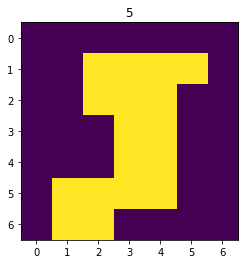

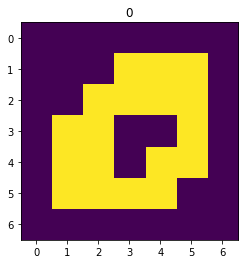

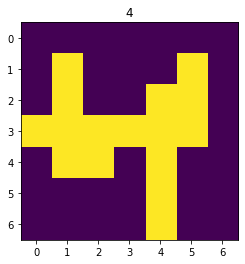

In [ ]:

from typing import Iterable
import torchfactors as tx
import torch
from dataclasses import dataclass

@dataclass
class MNISTExample(tx.Subject):
    pixels: tx.Var = tx.VarField(tx.Range(2), tx.OBSERVED)
    digit: tx.Var = tx.VarField(tx.Range(10), tx.ANNOTATED)
    
    @classmethod
    def from_huggin(cls, example, row_scale=1, col_scale=1, threshold=125):
        cols, rows = example['image'].size
        pixels = torch.tensor(
                [[float(example['image'].getpixel((c,r)))
                  for c in range(cols)]
                 for r in range(rows)])
        scaled = torch.tensor(
                [[pixels[(r-row_scale):r, (c-col_scale):c].max()
                   for c in range(col_scale, cols+1, col_scale)]
                  for r in range(row_scale, rows+1, row_scale)]).float()
        return MNISTExample(
            pixels=tx.TensorVar((scaled >= threshold).int()),
            digit=tx.TensorVar(torch.tensor(example['label']))
        )

# create subject instances from raw data
train_raw = mnist['train']
n_full = len(train_raw)
n_train = 5000
n_dev = 5000
n_dev_splits = 5
scale = 9

index_ranges = dict(
    train=range(n_train),
    **{
        f'dev{i}': range(end - n_dev, end)
        for i, end in enumerate(range(n_full, n_train, -n_dev)[:n_dev_splits])
    })

subjects = {
    name: [MNISTExample.from_huggin(train_raw[i], row_scale=scale, col_scale=scale) for i in index_range]
    for name, index_range in index_ranges.items()
}

# display some examples
num_examples_to_show = 3

from matplotlib import pyplot as plt

for i, xi in enumerate(subjects['train'][:num_examples_to_show]):
    plt.figure(i)
    plt.title(f'{int(xi.digit.tensor)}')
    plt.imshow(xi.pixels.tensor.numpy())

batches = {
    name: tx.Subject.stack(subs)
    for name, subs in subjects.items()
}


# Defining the Model
The model (family) is described as a class (specialized for the specified type
of Subject) that will hold all relevant parameters and defines a method that
generates factors given an instance of the subject type. The method may also
create additional latent variables.



In [ ]:
class CRF(tx.Model[MNISTExample]):
    def factors(self, x: MNISTExample) -> Iterable[tx.Factor]:
        rows, cols = x.pixels.shape[-2:]
        for r in range(rows):
            for c in range(cols):
                cell = x.pixels[...,r,c]
                yield tx.LinearFactor(self.namespace(f'unigram_{r}_{c}'), cell, x.digit)
                if r > 0:
                    above_cell = x.pixels[...,r-1,c]
                    yield tx.LinearFactor(self.namespace(f'bigram_with_above'), cell, above_cell, x.digit)
                if c > 0:
                    left_cell = x.pixels[...,r,c-1]
                    yield tx.LinearFactor(self.namespace(f'bigram_with_left'), cell, left_cell, x.digit)
                    # if r > 0:
                    #     corner_cell = x.pixels[...,r-1,c-1]
                    #     yield tx.LinearFactor(self.namespace(f'corner'), cell, corner_cell, x.digit)
                    #         yield tx.LinearFactor(self.namespace(f'position_{r}_{c}'), cell, input=x.digit.tensor)

system = tx.learning.example_fit_model(CRF(), subjects['train'], iterations=50, batch_size=n_train, lr=0.5, weight_decay=10.0)
for x in batches.values():
    x.pixels.clamp_annotated()
    
predictions = {
    name: system.predict(batch)
    for name, batch in batches.items()
}
accuracies = {
    name: (batches[name].digit.tensor == predictions[name].digit.tensor).float().mean()
    for name in predictions
}
print(accuracies)


2022-01-21 22:03:31,601 loading...
2022-01-21 22:03:31,604 done loading.
Subjects...: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
2022-01-21 22:03:32,094 staring training...
  0%|          | 0/50 [00:00<?, ?it/s]